\begin{align*}
    I[\bm{\xi}] &= \int_{\Omega} G(J_\xi, \det(J_\xi), M, \bm{x}) \, d\bm{x} \\
    \hat{I}[\bm{x}] &= \int_{\Omega_C} G(J_{x}^{-1}, \det(J_{x}^{-1}), M(x(\xi)), \bm{x(\xi)}) \, \det{J_{x}} \,d\bm{\xi}\\
    &=\sum_{K\in T_{c,h}}|K|G\det{J_x}
\end{align*}


# Dependence

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [2]:
steps = 10000
layers = np.array([2,32,64,32,2])
lr = 0.001

# Build mesh

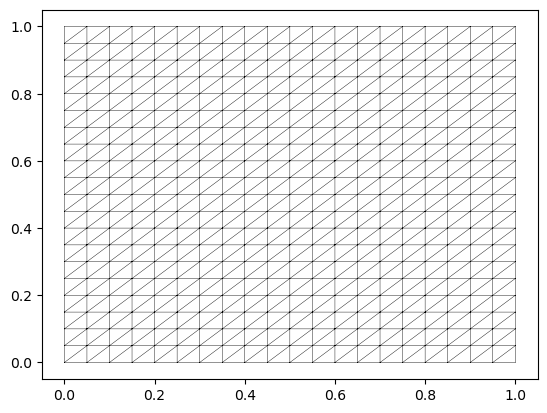

In [3]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
Vc = torch.stack([x,y],dim=1)

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris)

#boundarys = V[(V[:,0]==0.0) | (V[:,1]==0.0) | (V[:,0]==1.0) | (V[:,1]==1.0)]
left_boundarys = Vc[(Vc[:,0]==0.0)]
bottom_boundarys = Vc[(Vc[:,1]==0.0)]
top_boundarys = Vc[(Vc[:,1]==1.0)]
right_boundarys = Vc[(Vc[:,0]==1.0)]

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Moving Mesh Functions

In [4]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def metric(V):
    u_x_y = U_x_y(V)
    uxy_norm = torch.sqrt(0.1 * torch.linalg.norm(u_x_y,dim=1)**2 + 1)
    return torch.diag_embed(uxy_norm.unsqueeze(-1).expand(-1,2),dim1=-2,dim2=-1)
    
# def metric(V):
#     u_x_y = U_x_y(V)
#     col = u_x_y.unsqueeze(2)
#     row = u_x_y.unsqueeze(1)
#     u_x_y_2 = col@row
#     u_x_y_2[:,0,0] += 1
#     u_x_y_2[:,1,1] += 1
#     return u_x_y_2
#     eigenvalues, eigenvectors = torch.linalg.eigh(u_x_y_2)
#     sqrt_eigenvalues = torch.sqrt(eigenvalues)
#     return eigenvectors @ torch.diag_embed(sqrt_eigenvalues) @ eigenvectors.transpose(1,2)

# Auxiliary Functions


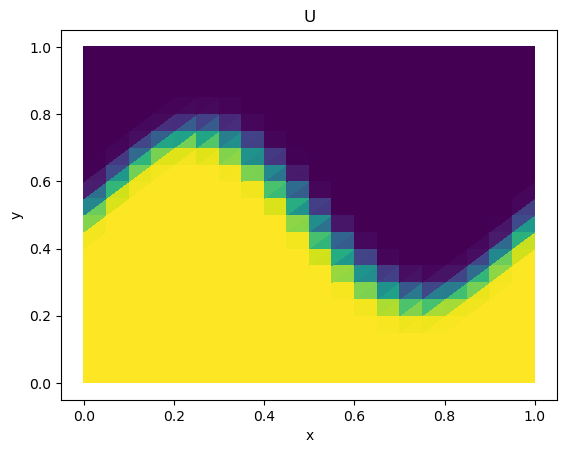

In [5]:
def area(V,tris):
    v1,v2,v3 = V[tris[:,0]],V[tris[:,1]],V[tris[:,2]]
    return 0.5*torch.abs((v2[:,0]-v1[:,0])*(v3[:,1]-v1[:,1])-(v3[:,0]-v1[:,0])*(v2[:,1]-v1[:,1]))
    
def centroid(V,tris):
    return (V[tris[:,0]]+V[tris[:,1]]+V[tris[:,2]])/3.0

def Plot(V, U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()
    
Plot(Vc,U(Vc))

# Neural Network

In [6]:

class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def jacobian(self,V):
        V.requires_grad = True
        xy = self.forward(V)
        x = xy[:,0].unsqueeze(1)
        y = xy[:,1].unsqueeze(1)
        dx = autograd.grad(x,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        dy = autograd.grad(y,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        return torch.stack([dx,dy],dim=1)

    def loss_BC(self,BC):
        # return self.loss_function2(self.forward(BC[0,:,:2])[:,0],BC[0,:,2]) + \
        #        self.loss_function2(self.forward(BC[1,:,:2])[:,0],BC[1,:,2]) + \
        #        self.loss_function2(self.forward(BC[2,:,:2])[:,1],BC[2,:,2]) + \
        #        self.loss_function2(self.forward(BC[3,:,:2])[:,1],BC[3,:,2])
        return self.loss_function2(self.forward(BC[0,:,:2]),BC[0,:,:2]) + \
               self.loss_function2(self.forward(BC[1,:,:2]),BC[1,:,:2]) + \
               self.loss_function2(self.forward(BC[2,:,:2]),BC[2,:,:2]) + \
               self.loss_function2(self.forward(BC[3,:,:2]),BC[3,:,:2])
    
    def loss_G(self,Vc,tris):
        areas = area(Vc,tris)
        centroids_c = centroid(Vc,tris)
        #cx = self.forward(centroids)
        V = self.forward(Vc)
        centroids = centroid(V,tris)
        J = self.jacobian(centroids_c)
        detJ = torch.linalg.det(J)
        Jinv = torch.linalg.inv(J)
        JinvT = Jinv.transpose(1,2)
        M = metric(centroids)
        M_inv = torch.linalg.inv(M)
        JMJ = Jinv@M_inv@JinvT
        traces = JMJ[:,0,0] + JMJ[:,1,1]  
        return torch.sum(areas*traces*detJ)

    def loss(self,Vc,tris,BC):      
        return self.loss_G(Vc,tris) + self.loss_BC(BC)
        
        # V.requires_grad = True
        # V_ref.requires_grad = True
        # J = self.jacobian(V_ref,V,tris)
        # JT = J.transpose(1,2)
        # vol = self.area(V,tris)
        # JJT = torch.bmm(J,JT)
        # traces = JJT[:,0,0] + JJT[:,1,1]
        # return torch.dot(vol, traces)

# Train Neural Network

C:\Users\13162\AppData\Local\Temp\ipykernel_7792\2455172087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tris = torch.tensor(tris,dtype=torch.long).to(device)


0 61.389885
1 49.24316
2 39.42944
3 31.427225
4 24.912563
5 21.80006
6 19.97309
7 16.909897
8 14.4426565
9 16.94524
10 18.064955
11 16.728682
12 13.520251
13 9.831063
14 8.124359
15 8.999857
16 9.418306
17 9.930242
18 10.929645
19 10.546085
20 9.139705
21 7.6881423
22 6.475703
23 5.5175195
24 6.0131702
25 6.9364567
26 6.705938
27 5.746793
28 5.2138157
29 4.9484725
30 5.020548
31 5.1853027
32 4.7850556
33 4.507696
34 4.050927
35 4.314109
36 4.557153
37 4.8195043
38 4.688018
39 4.385886
40 4.2063437
41 4.1059055
42 4.182109
43 4.03273
44 4.042103
45 4.0713987
46 4.2023635
47 4.0464473
48 3.900848
49 3.8799434
50 3.856643
51 3.785684
52 3.803096
53 3.8351166
54 3.8637733
55 3.885466
56 3.8070765
57 3.7484934
58 3.7198594
59 3.990715
60 3.9541967
61 3.7633529
62 3.9265711
63 3.6477365
64 3.6832538
65 3.7180312
66 3.6390018
67 3.6290445
68 3.6269338
69 3.6402636
70 3.5673566
71 3.5615811
72 3.5638103
73 3.4802482
74 3.4862404
75 3.550662
76 3.612192
77 3.546152
78 3.61595
79 3.5370038
80 3.

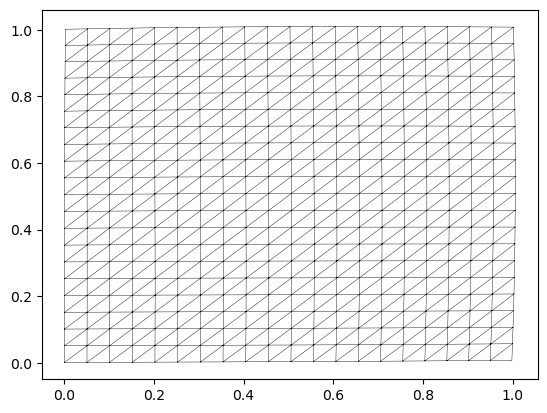

In [7]:
Vc = Vc.float().to(device)
tris = torch.tensor(tris,dtype=torch.long).to(device)

BC1 = torch.cat((left_boundarys,torch.zeros(left_boundarys.shape[0],1)),dim=1)
BC2 = torch.cat((right_boundarys,torch.ones(right_boundarys.shape[0],1)),dim=1)
BC3 = torch.cat((bottom_boundarys,torch.zeros(bottom_boundarys.shape[0],1)),dim=1)
BC4 = torch.cat((top_boundarys,torch.ones(top_boundarys.shape[0],1)),dim=1)
BC = torch.stack((BC1,BC2,BC3,BC4),dim=0).to(device)

MMPDE_Net = FCN(layers)
MMPDE_Net.to(device)
params = list(MMPDE_Net.parameters())
optimizer = torch.optim.Adam(MMPDE_Net.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = MMPDE_Net.loss(Vc,tris,BC)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
new_V = MMPDE_Net(Vc).detach().cpu()
plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)